In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption
import copy
from IPython.display import display

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm

from causal_optoconnectics.core import hit_rate

In [2]:
plt.rcParams['figure.figsize'] = (16,9)

In [ ]:
from params_test import parameters
sim = Simulator(
    parameters, fname='network_raster', data_path='results', 
    stim_dist='poisson', verbose=True,
    stim_amp_ex=0, stop_time=1.)
sim.simulate(state=False, save=False, raster=False, progress_bar=tqdm)

# sim.plot_raster(xlim=[800,1000])

data = sim.data

Setting kernel
Setting neurons
Setting background
Connecting background rate =  5.0 C =  2000
Setting connections
Connecting excitatory neurons J =  0.68 C =  1600
Connecting inhibitory neurons J =  -11.9 C =  400
Setting stimulation
Setting spike recording
Simulating 5 trials, total 1144.8 ms


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [ ]:
senders = sim.data['spiketrains']['ex']['senders']
times = sim.data['spiketrains']['ex']['times']
stim_times = sim.data['epoch']['times']
sender_ids = np.unique(senders)

spiketrains = {
    sender: times[sender==senders] for sender in tqdm(sender_ids)}

In [ ]:
conn = sim.data['connections']
conn.weight[conn.weight > 0].std()

In [ ]:
plt.figure()
conn.weight.hist(bins=1000)
plt.grid(False)
plt.xlabel('Synaptic weight [pA]')

In [ ]:
t_stop = sim.p['status']['time']

In [ ]:
plt.hist([len(s) / (t_stop / 1000) for s in spiketrains.values()]);

In [ ]:
fig, ax = plt.subplots(1, 2)


binsize_corr = 2.
spiketrains_list = list(spiketrains.values())
spiketrains_sampled = [spiketrains_list[i] for i in np.random.randint(0, len(spiketrains_list), 200)]
cc = corrcoef(
    spiketrains_sampled, t_stop, binsize=binsize_corr)

cc = cc[np.triu_indices(len(cc), k=1)]
cc = cc[~np.isnan(cc)]
ax[0].hist(cc, bins=100);


cv = np.array(coef_var(spiketrains_sampled))
cv = cv[~np.isnan(cv)]

ax[1].hist(cv, bins=100);

In [ ]:
np.mean(cc), np.mean(cv)

In [11]:
def prestim(x, stim_times):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')

    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    return x[src_x-1] - stim_times

In [12]:
conn.loc[:,'source_stimulated'] = conn.source.isin(data['stim_nodes']['ex'])
conn.loc[:,'target_stimulated'] = conn.target.isin(data['stim_nodes']['ex'])
conn['stim_amp_source'] = conn.progress_apply(lambda x: data['stim_amps']['ex'].get(x.source, 0), axis=1)

HBox(children=(IntProgress(value=0, max=1600000), HTML(value='')))

In [28]:
As = conn.query("stim_amp_source == 400").sort_values('weight', ascending=False).iloc[3]
A = As.source
C = As.target

Bs = conn.query("source!={A} and target!={C} and stim_amp_source == 400".format(A=A, C=C))
B = Bs.source.iloc[2]

In [29]:
A_prestim = prestim(spiketrains[A], data['epoch']['times'])
B_prestim = prestim(spiketrains[B], data['epoch']['times'])

np.corrcoef(A_prestim, B_prestim)[0,1]

0.029289639873618392

In [30]:
print(A_prestim.shape, B_prestim.shape)

(40,) (40,)


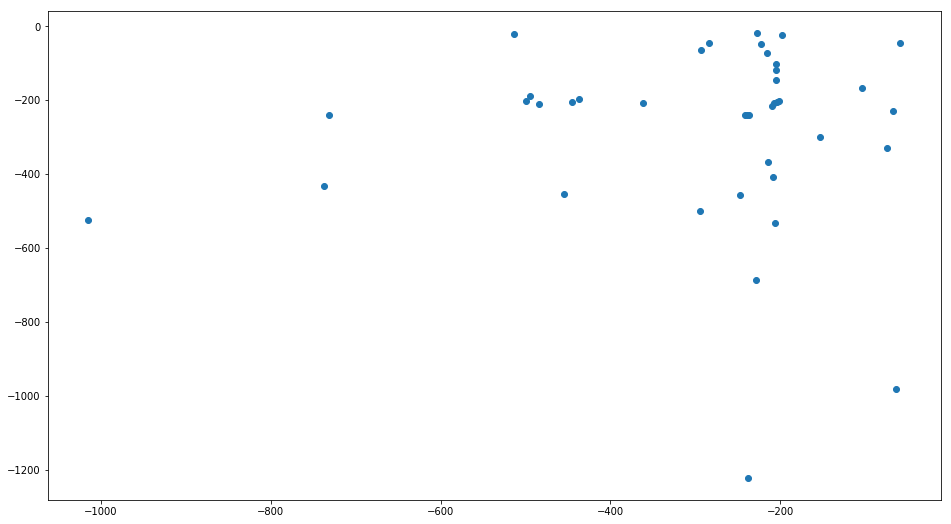

In [31]:
plt.scatter(A_prestim, B_prestim)

(3.0009787938479033, 0.5307452322737473)

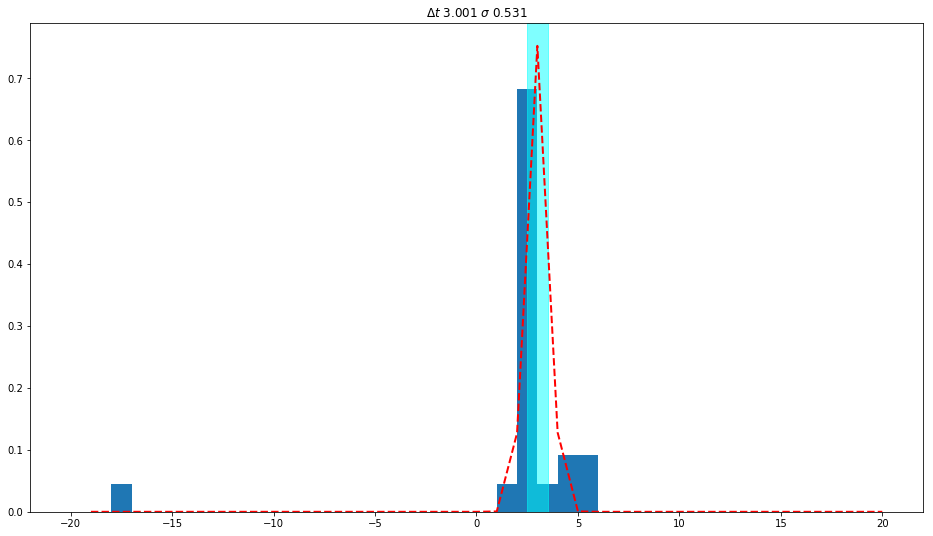

In [17]:
from causal_optoconnectics.cch import fit_latency
fit_latency(data['epoch']['times'], spiketrains[A], plot=True, bin_size=1, limit=20, init=[5,5])

Text(0.5,0,'Hit rate')

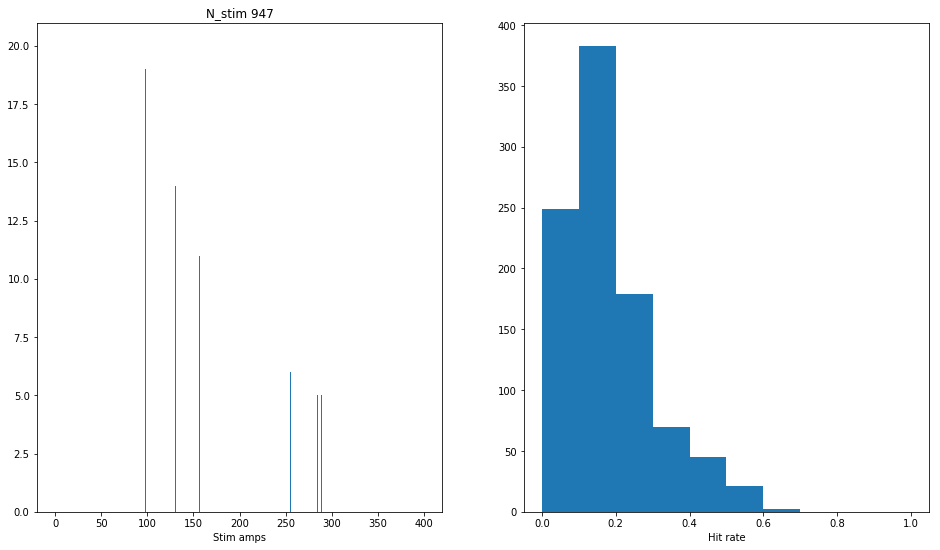

In [18]:
mu = 4
sigma = 3 # not used
hit_rates = [hit_rate(s, stim_times,  mu=mu, sigma=sigma)
             for i, s in spiketrains.items() if i in sim.data['stim_nodes']['ex']]


fig, ax = plt.subplots(1, 2)

amps = np.array(list(sim.data['stim_amps']['ex'].values()))
width = .1
bins = np.arange(0, amps.max(), width)
hist, bins = np.histogram(amps, bins=bins)
ax[0].set_title('N_stim {}'.format(sum(hist)))
ax[0].bar(bins[1:], hist, align='edge', width=-width)
ax[0].set_xlabel('Stim amps')

width = .1
bins = np.arange(0, 1+width, width)
hist, bins = np.histogram(hit_rates, bins=bins)
ax[1].bar(bins[1:], hist, align='edge', width=-width)
ax[1].set_xlabel('Hit rate')

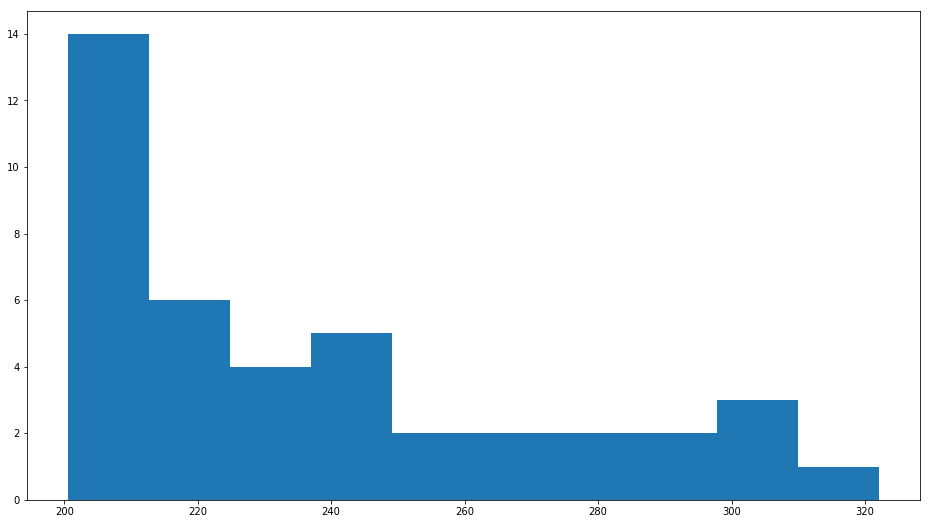

In [19]:
plt.hist(np.diff(data['epoch']['times']));

In [ ]:
np.rave